## Final Model (Weekly)
*Analyst:* José Eduardo Téllez


### Objetive
This notebook aims to generate the final model. 
In the previous script, we attempted to develop a daily model, but it resulted in poor metrics. 
As we observed in the exploratory data analysis (01_eda.R), using more aggregated data could help reduce variability.



### DATA

The data has the next variables and is saved in cache folder as  'prep_data.csv'
* ggsearch:  Google spending
* facebook:  Facebook spending
* display:  Display spending
* promotion:  Promotions (0,1) 
* day:  Day of the week
* month:  Month
* leads_n:  Number of leads in that date
* days_considered:  Number of days to be Qualified. 
* considered_leads_n:  Number of leads Qualified
* days_purchase:  Days taken to complete a purchase.
* purchase_leads:  Number of leads that completed a purchase THE DATE OF THE PURCHASE.
* time_to_purchase:  Time taken from lead TO PURCHASE THE DATE OF BEEN IDENTIFEID AS LEAD.
* purchase_leads_fur:  number of leads that completed a purchase THE DATE OF BEEN IDENTIFIED AS LEAD.






## 1. Import data
In this section, we defined modules to used. 

In [2]:
import pandas as pd
import numpy as np
import sys
import os

## modeling modules
from sklearn.linear_model import LinearRegression, Ridge ,ElasticNet, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, r2_score

from statsmodels.stats.outliers_influence import variance_inflation_factor


## 2. Define Path
In this section, we defined the path that would be used. 

In [3]:
main_path = os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd())))

In [4]:
sys.path.append(os.path.join(main_path, 'lib'))

## Read Data

In [5]:
data = pd.read_csv(os.path.join(main_path, 'cache/prep_data.csv'))
data['date'] = pd.to_datetime(data['date'])

In [6]:
data.head(10)

,Unnamed: 0,date,ggsearch,facebook,display,promotion,day,month,leads_n,days_considered,considered_leads_n,days_purchase,purchase_leads,time_to_purchase,purchase_leads_fur
0,0,2022-02-04,2424.34,200.72,284,0,Friday,February,1,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2022-02-05,2110.07,407.44,194,0,Saturday,February,8,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2022-02-06,2091.32,395.24,247,0,Sunday,February,4,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2022-02-07,2867.82,415.98,211,0,Monday,February,21,0.0,0.0,0.0,0.0,66.0,1.0
4,4,2022-02-08,2569.72,433.87,283,0,Tuesday,February,17,0.0,0.0,0.0,0.0,0.0,0.0
5,5,2022-02-09,2808.94,427.29,135,0,Wednesday,February,19,1.0,2.0,0.0,0.0,222.0,1.0
6,6,2022-02-10,2728.04,425.30,281,0,Thursday,February,18,0.0,0.0,0.0,0.0,0.0,0.0
7,7,2022-02-11,2477.71,434.02,200,0,Friday,February,15,0.0,0.0,0.0,0.0,81.0,1.0
8,8,2022-02-12,1789.40,419.92,263,0,Saturday,February,10,0.0,0.0,0.0,0.0,0.0,0.0
9,9,2022-02-13,1983.92,400.09,175,0,Sunday,February,8,0.0,0.0,0.0,0.0,0.0,0.0


data.info()

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 939 entries, 0 to 938
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Unnamed: 0          939 non-null    int64         
 1   date                939 non-null    datetime64[ns]
 2   ggsearch            939 non-null    float64       
 3   facebook            939 non-null    float64       
 4   display             939 non-null    int64         
 5   promotion           939 non-null    int64         
 6   day                 939 non-null    object        
 7   month               939 non-null    object        
 8   leads_n             939 non-null    int64         
 9   days_considered     939 non-null    float64       
 10  considered_leads_n  939 non-null    float64       
 11  days_purchase       939 non-null    float64       
 12  purchase_leads      939 non-null    float64       
 13  time_to_purchase    939 non-null    float64       

## Transformations

We will generate additional variables, including lag variables, log-transformed variables, as well as year, month, and quarter indicators.


In [8]:
data_tr = data.drop(columns=['day']).resample("W", on ='date').sum().copy()
data_tr = data_tr.reset_index()
data_tr['year'] = data_tr['date'].dt.year
data_tr['month'] = data_tr['date'].dt.month
data_tr['quarter'] = data_tr['date'].dt.quarter
columns_numeric = [	'ggsearch',	'facebook',	'display',	'promotion']

# Create new columns with log-transformed values
for col in columns_numeric:
    lag_col_name = f"{col}_lag1"
    data_tr[lag_col_name] = data_tr[col].shift(1)
    data_tr[lag_col_name] = data_tr[lag_col_name].fillna(0)

    log_col_name = f'log_{col}'
    data_tr[log_col_name] = data_tr[col].apply(lambda x: np.log(x+ 0.00001))
    data_tr[log_col_name] = data_tr[log_col_name].fillna(0)

data_tr.columns

Index(['date', 'Unnamed: 0', 'ggsearch', 'facebook', 'display', 'promotion',
       'month', 'leads_n', 'days_considered', 'considered_leads_n',
       'days_purchase', 'purchase_leads', 'time_to_purchase',
       'purchase_leads_fur', 'year', 'quarter', 'ggsearch_lag1',
       'log_ggsearch', 'facebook_lag1', 'log_facebook', 'display_lag1',
       'log_display', 'promotion_lag1', 'log_promotion'],
      dtype='object')

We also transformed  date variables to dummies

In [9]:
dt_dummies = pd.get_dummies(data_tr, columns=['year', 'quarter','month'], 
                                  dtype=float ,
                                  drop_first=True
                                  )

In [10]:
dt_dummies.groupby('purchase_leads').agg({'Unnamed: 0':'count'})

,Unnamed: 0
purchase_leads,
0.0,23
1.0,26
2.0,40
3.0,17
4.0,14
5.0,10
6.0,2
7.0,3


## Correlation matrix
This will give us a goog understand of what variables can be useful


In [11]:
col_cor = [col for col in dt_dummies.columns if 'ggsearch' in col] +[col for col in dt_dummies.columns if 'facebook' in col
                                                           ] +[col for col in dt_dummies.columns if 'display' in col]  +['leads_n', 'purchase_leads_fur']
dt_dummies[col_cor].corr()


,ggsearch,ggsearch_lag1,log_ggsearch,facebook,facebook_lag1,log_facebook,display,display_lag1,log_display,leads_n,purchase_leads_fur
ggsearch,1.000000,0.658458,0.982481,0.301262,0.325586,0.361459,0.238917,0.259660,0.247788,0.582535,0.071964
ggsearch_lag1,0.658458,1.000000,0.659510,0.259677,0.348840,0.327313,0.255403,0.407998,0.267924,0.408175,0.009255
log_ggsearch,0.982481,0.659510,1.000000,0.334280,0.365901,0.401008,0.304068,0.342302,0.325225,0.608533,0.096004
facebook,0.301262,0.259677,0.334280,1.000000,0.945330,0.992337,-0.235898,-0.119784,-0.173340,0.296437,-0.049292
facebook_lag1,0.325586,0.348840,0.365901,0.945330,1.000000,0.944616,-0.239983,0.015733,-0.169854,0.300356,-0.122957
log_facebook,0.361459,0.327313,0.401008,0.992337,0.944616,1.000000,-0.163252,-0.048011,-0.098584,0.359198,-0.031373
display,0.238917,0.255403,0.304068,-0.235898,-0.239983,-0.163252,1.000000,0.608711,0.988525,0.271939,0.320998
display_lag1,0.259660,0.407998,0.342302,-0.119784,0.015733,-0.048011,0.608711,1.000000,0.670437,0.221991,0.148983
log_display,0.247788,0.267924,0.325225,-0.173340,-0.169854,-0.098584,0.988525,0.670437,1.000000,0.273678,0.303228
leads_n,0.582535,0.408175,0.608533,0.296437,0.300356,0.359198,0.271939,0.221991,0.273678,1.000000,0.177387


## Model

In [12]:
## Models

### We are going to uses linear methods
seed =  2024
lr = LinearRegression()
ridge = Ridge(random_state=seed)
lasso = Lasso(random_state=seed)
elnet = ElasticNet(random_state=seed)


### Dictionary with the models
modelos ={
    "Linear" :lr,
    "Ridge":ridge,
    'Lasso':lasso,
    'elasticnet':elnet}

In [46]:
dt_dummies.to_csv(os.path.join(main_path,"cache/Final_data_model.csv"))

In [21]:
## Define the target variables
target = 'leads_n'

## Select variables to the model
selected_vars = [ 
      #   'ggsearch', 
      #   'facebook',
      #   'display', 
       'promotion',
    #    'leads_n', 
        # 'ggsearch_lag1', 
        'log_ggsearch',
        # 'facebook_lag1',
       'log_facebook', 
      #  'display_lag1', 
       'log_display', 
      #  'promotion_lag1',
      #  'log_promotion',
      #  'day_Monday', 
      #  'day_Saturday', 
      #  'day_Sunday',
      # 'day_Thursday',
      #  'day_Tuesday',
      #    'day_Wednesday'
      #  ] + [col for col in dt_dummies.columns if 'year' in col
            
# + [col for col in dt_dummies.columns if 'quarter' in col 
]+ [col for col in dt_dummies.columns if 'month_' in col]


## variables
X = dt_dummies[selected_vars]

## since we are modeling frequency we need to model a log(x) model as the target is Poisson
y = np.log(dt_dummies[target])

In [22]:
## SPlit the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=seed)

In [23]:
model_fit = {}

## Compare models, check metrics, 
## We are using MAPE 
for name, model in modelos.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_train)
    metrics = [100*mean_absolute_percentage_error(np.exp(y_train), np.exp(pred)), r2_score(np.exp(y_train), np.exp(pred))]
    pred_test = model.predict(X_test)
    metrics_test = [100*mean_absolute_percentage_error(np.exp(y_test), np.exp(pred_test)), r2_score(np.exp(y_test), np.exp(pred_test))]
    print( f'{name}: Train -MAPE:{metrics[0]}; R2: {metrics[0]}')
    print( f'{name}: Test -MAPE:{metrics_test[0]}; R2: {metrics_test[0]}')

    model_fit[name] = model
    
### The Linear model has the lowest train Mape and Test MApe


Linear: Train -MAPE:13.066315682573082; R2: 13.066315682573082
Linear: Test -MAPE:17.75826224793869; R2: 17.75826224793869
Ridge: Train -MAPE:14.319841940973928; R2: 14.319841940973928
Ridge: Test -MAPE:17.15614383413559; R2: 17.15614383413559
Lasso: Train -MAPE:27.094812893184788; R2: 27.094812893184788
Lasso: Test -MAPE:19.69411024833849; R2: 19.69411024833849
elasticnet: Train -MAPE:27.094812893184788; R2: 27.094812893184788
elasticnet: Test -MAPE:19.69411024833849; R2: 19.69411024833849


In [24]:
### Calculate Pred
pred = lr.predict(X_train)
P_train = pd.DataFrame(np.exp(pred) ,columns=["pred"])


### Calculate pPred Test
pred_test = lr.predict(X_test)
P_test = pd.DataFrame(np.exp(pred_test), columns=["pred"])


In [25]:
## Concatenate Y varibles to plot
Y_pred = pd.concat([P_train, P_test], axis=0)
Y_actual = pd.concat([np.exp(y_train), np.exp(y_test)], axis=0)

Y_pred = Y_pred.reset_index(drop=True)
Y_actual = Y_actual.reset_index(drop=True)
pd.concat([Y_pred, Y_actual], axis = 1)

,pred,leads_n
0,135.984217,161.0
1,84.332216,122.0
2,74.628392,82.0
3,90.087820,82.0
4,93.627712,128.0
...,...,...
130,91.951477,91.0
131,53.322563,103.0
132,69.918464,60.0
133,131.473126,107.0


In [26]:
## Lets visualize the coeficients
imps = pd.DataFrame({
    'Vars': lr.feature_names_in_,
    'imps': lr.coef_
})

imps.sort_values(by ='imps', ascending=False)


,Vars,imps
3,log_display,1.263058
1,log_ggsearch,0.537447
4,month_2,0.378222
2,log_facebook,0.294381
11,month_9,0.258627
14,month_12,0.232572
13,month_11,0.227611
6,month_4,0.225942
10,month_8,0.200312
12,month_10,0.192129


In [ ]:
## Let's use OLS from statsmodels to check p-values and coefficients.
## Similar to the linear regression models, display and ggsearch seem to have the greatest impact.
## display is unusual, as it did not show a strong relationship in the EDA.
## We will check the VIF to investigate potential collinearity issues.
import statsmodels.api as sm
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                leads_n   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.582
Method:                 Least Squares   F-statistic:                     13.43
Date:                Mon, 04 Nov 2024   Prob (F-statistic):           3.57e-19
Time:                        09:34:01   Log-Likelihood:                 38.784
No. Observations:                 135   AIC:                            -45.57
Df Residuals:                     119   BIC:                            0.9172
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -11.2665      1.522     -7.404   

In [ ]:
vif = pd.DataFrame()
pd.DataFrame(X.columns).head(5)


,0
0,const
1,promotion
2,log_ggsearch
3,log_facebook
4,log_display


In [ ]:
variance_inflation_factor(X.values, 1)
variance_inflation_factor(X.values, 2)
variance_inflation_factor(X.values, 3)
variance_inflation_factor(X.values, 4)

## Checking multicollinearity:
#  all values are below 4, so we can conclude that it is not a collinearity problem.


np.float64(1.2850560880386008)

## Pred vs Real

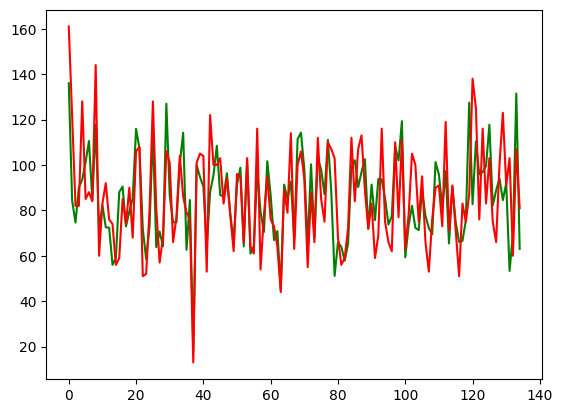

In [ ]:
import matplotlib.pyplot as plt
plt.plot( Y_pred['pred'], 'g-', label='Predicted sales')
actual, = plt.plot(Y_actual.index, Y_actual, 'r-', label='Actual sales')
plt.show()

## As we can see in the plot, the predictions closely resemble the real values in terms of trend.


### Final Results
Since we are using a log-log model, we need to transform the coefficients to interpret their real impact.
The simplest way is to interpret them as elasticity.



In [45]:
def elasticidades(change, coef):
    return 100*((1+change)**coef -1)

variable_names = model.model.exog_names  
coefficients = model.params  
p_values = model.pvalues  

params_ctr = pd.DataFrame({'variable': variable_names, 'coefs': coefficients, 'p_values': p_values}).reset_index().drop('index', axis=1)
change = 0.1

params_final = params_ctr.copy()

params_final['elasticity'] = params_final['coefs'].apply(lambda x: elasticidades(change, x))
params_final = params_final[params_final['variable'].str.contains('log')]
params_final['variable'] = params_final['variable'].str.replace('log_', '')
params_final = params_final.sort_values(by = 'elasticity', ascending=False)
params_final

,variable,coefs,p_values,elasticity
4,display,1.182046,2.644572e-07,11.925243
2,ggsearch,0.544667,1.884192e-08,5.328333
3,facebook,0.201639,3.000210e-04,1.940415


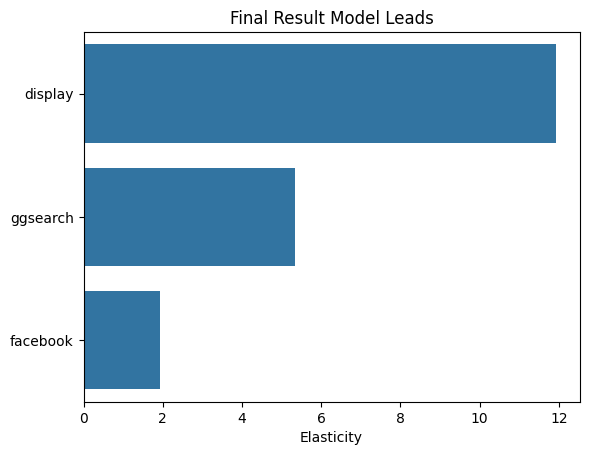

In [44]:
import seaborn as sns

sns.barplot(data= params_final, y = 'variable', x = 'elasticity' )
plt.title("Final Result Model Leads")
plt.ylabel("")
plt.xlabel("Elasticity")

plt.show()


### Conclusion

In the analysis, we observed that `ggsearch` initially showed a stronger one-to-one relationship with the number of leads. However, when working with weekly data and using a multiple regression model, `display` emerged as more relevant. Additionally, when comparing costs, `display` proved to be the most cost-effective, while `ggsearch` was the most expensive. Based on this analysis, I would recommend prioritizing spending on `display`, followed by `ggsearch`, and finally `facebook`.

- **Display**: A 10% increase in display spending is associated with a 12% increase in the number of leads.
- **GGsearch**: A 10% increase in ggsearch spending results in a 5% increase in the number of leads.
- **Facebook**: A 10% increase in Facebook spending leads to a 2% increase in the number of leads.


## Next steps


We prioritized the analysis on the number of leads, but for further analysis, I would suggest examining the time it takes for leads to become qualified. There may be a relationship between certain media channels and the speed at which leads are qualified. This approach could provide additional insights for future recommendations.
